# Testing HNC initial guesses and updates

## import

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as const

## constants

In [22]:
const.k_gro = const.k * const.N_A * 1e-3
BAR_PER_MD_PRESSURE = 16.6053904
G_MIN = 1e-10

## load hexane data

In [23]:
kBT = const.k_gro * 273.15
density = 2000 / 7.53125**3  # n/V in nm^-3
cut_off = 1.5

In [24]:
r = np.loadtxt('r.txt')
rdf_target = np.loadtxt('rdf_target.txt')
rdf_current = np.loadtxt('rdf_current.txt')
rdf_incl = np.loadtxt('rdf_incl.txt')
pot_current = np.loadtxt('pot_current.txt')  # HNC (no bonds) init
pot_10stepsIHNC = np.loadtxt('pot_10stepsIHNC.txt')  # not fully converged but good for comparison

## plot input data

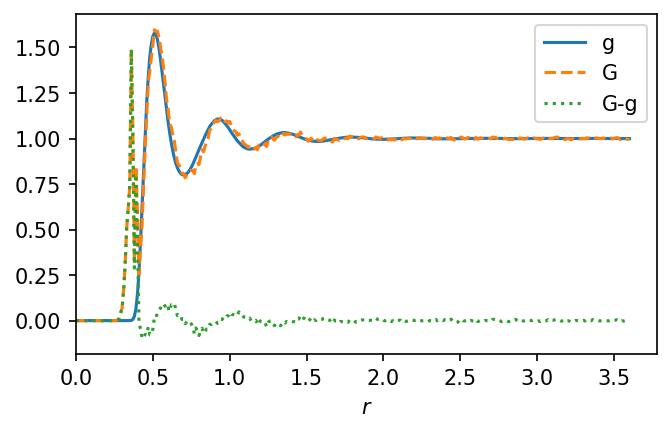

In [25]:
mpl_rc = {
    'figure.dpi': 150,
}

with mpl.rc_context(rc=mpl_rc):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(r, rdf_current, label='g')
    ax.plot(r, rdf_incl, '--', label='G')
    ax.plot(r, rdf_incl - rdf_current, ':', label='G-g')
    ax.legend()
    ax.set_xlabel(r'$r$')
    ax.set_xlim(0)
    plt.show()

## Use HNC (without and with bonds) for inital guess

In [26]:
def fourier(r, y, omega):
    Delta_r = r[1] - r[0]
    y_hat = np.zeros_like(omega)
    np.seterr(divide='ignore', invalid='ignore', under='ignore')
    for i, omega_i in enumerate(omega):
        y_hat[i] = 2 / omega_i * Delta_r * np.sum(r * y * np.sin(2 * np.pi * omega_i * r))
    np.seterr(all='raise')
    return y_hat

In [27]:
def calc_pot_hnc(r, g, kBT, rho, G=None):
    """calculates U from g (normal RDF)
    
    if G (RDF including intramolecular atoms) is not None
    it takes into account intramolecular interactions for molecules 
    with two beads"""
    
    # total correlation function h
    h = g - 1

    # Fourier of h
    omega = np.arange(1, len(r)) / (2 * max(r))
    h_hat = fourier(r, h, omega)
    
    if G is None:
        # direct correlation function c
        c_hat = h_hat / (1 + rho * h_hat)
    else:
        # total correlation function H (includes intramolecular)
        H = G - 1
        H_hat = fourier(r, H, omega)
        # direct correlation function c
        c_hat = h_hat / ((1 + 1/2*rho*(H_hat - h_hat)) * ((1 + 1/2*rho*(H_hat - h_hat)) + rho * h_hat))
        
    c = fourier(omega, c_hat, r)
    
    np.seterr(divide='ignore', invalid='ignore')
    U = -kBT * np.log(g) + kBT * (h - c)
    np.seterr(all='raise')

    return U

In [28]:
pot_hnc = calc_pot_hnc(r, rdf_target, kBT, density, G=None)
pot_hnc_bonds = calc_pot_hnc(r, rdf_target, kBT, density, G=rdf_incl)

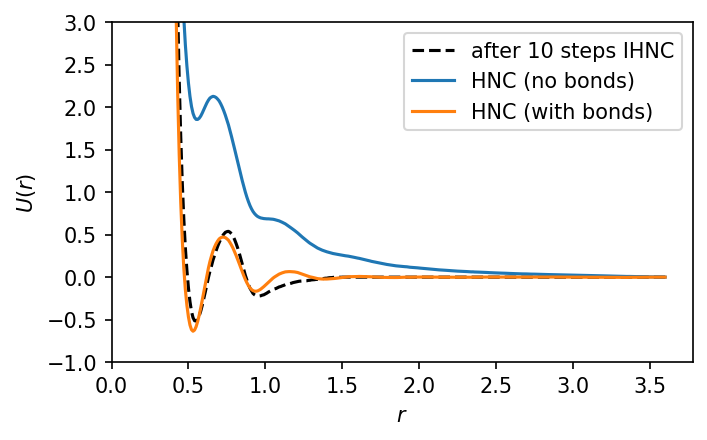

In [29]:
# plot the results
mpl_rc = {
    'figure.dpi': 150,
}

with mpl.rc_context(rc=mpl_rc):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(r, pot_10stepsIHNC, 'k--', label='after 10 steps IHNC')
    ax.plot(r, pot_hnc, label='HNC (no bonds)')
    ax.plot(r, pot_hnc_bonds, label='HNC (with bonds)')
    ax.legend()
    ax.set_xlabel(r'$r$')
    ax.set_ylabel(r'$U(r)$')
    ax.set_xlim(0)
    ax.set_ylim(-1, 3)
    plt.show()

This seems to work which indicates that taking into account the bonds and calculating $U(g, G)$ is working better than $U(g)$ (no bonds).

So I would expect to also have better convergence using the derivative of that inverse Henderson map.

## Do one IHNC step (without and with bonds)

In [30]:
def calc_dpot_hnc(r, g, g_k, kBT, rho, G=None, method='IHNC'):
    """calculates ΔU from g (target RDF), g_k (current RDF)
    
    if G (current RDF including intramolecular atoms) is not None
    it takes into account intramolecular interactions for molecules 
    with two beads"""
    
    # total correlation function h
    h = g - 1
    
    # difference of current to target 'f'
    f = g - g_k

    # Fourier of h
    omega = np.arange(1, len(r)) / (2 * max(r))
    h_hat = fourier(r, h, omega)
    
    # Fourier of f
    f_hat = fourier(r, f, omega)
    
    if G is None:
        # direct correlation function c
        b_hat = f_hat / (1 + rho * h_hat)**2
    else:
        # total correlation function H (includes intramolecular)
        H = G - 1
        H_hat = fourier(r, H, omega)
        # Fourier of a
        a_hat = 1 + rho/2 * (H_hat - h_hat)
        # Fourier of b
        b_hat = f_hat / (a_hat + rho * h_hat)**2
    b = fourier(omega, b_hat, r)
    
    # first term of dU
    np.seterr(divide='ignore', invalid='ignore')
    if method == 'HNCN':
        dU_first_term = -kBT * (f / g)
    elif method == 'IHNC':
        dU_first_term = kBT * np.log(g_k / g)
    else:
        raise Exception(f'method {method} not implemented')
    np.seterr(all='raise')
    
    dU = dU_first_term + kBT * (f - b)
    
    return dU

In [31]:
dpot_hnc = calc_dpot_hnc(r, rdf_target, rdf_current, kBT, density, G=None, method='IHNC')
dpot_hnc_bonds = calc_dpot_hnc(r, rdf_target, rdf_current, kBT, density, G=rdf_incl, method='IHNC')

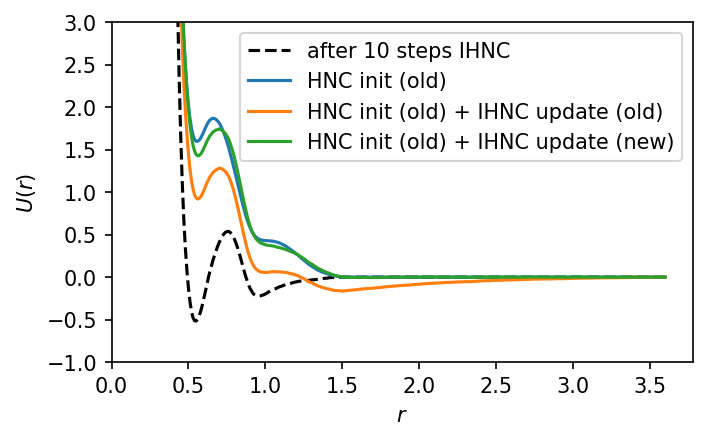

In [32]:
# plot the results
mpl_rc = {
    'figure.dpi': 150,
}

with mpl.rc_context(rc=mpl_rc):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(r, pot_10stepsIHNC, 'k--', label='after 10 steps IHNC')
    ax.plot(r, pot_current, label='HNC init (old)')
    ax.plot(r, pot_current + dpot_hnc, label='HNC init (old) + IHNC update (old)')
    ax.plot(r, pot_current + dpot_hnc_bonds, label='HNC init (old) + IHNC update (new)')
    ax.legend()
    ax.set_xlabel(r'$r$')
    ax.set_ylabel(r'$U(r)$')
    ax.set_xlim(0)
    ax.set_ylim(-1, 3)
    plt.show()

So appareantly the update taking into account $G$ and thereby the bonds is worse. Maybe I messed up the derivative.